# GONZAG WestMed example

This notebook demonstrates how Gonzag can be used to:
- perform a space-time interpolation of SSH on a gridded OGCM domain onto a satellite track (provided in 2 NetCDF input files)
- select and retain N valid SSH along track segments (both for input satellite SSH and interpolated model SSH)
- preprocess these N SSH segments prior to applying a Fast Fourrier Transform (FFT)
- apply the FFT
- plot the the mean spectrum (of the N spectra)

## Loading & initializations

In [7]:
import sys
import os
import glob
from os import getenv
import warnings
warnings.filterwarnings("ignore")

import numpy as nmp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

GONZAG_DIR   = '/Users/auraoupa/Work/git/gonzag_cloud'
sys.path.append(GONZAG_DIR)

import gonzag as gz
import xarray as xr

GONZAG_DATA_DIR = '/Users/auraoupa/Data/gonzag/gonzag_input'

# Satellite input data:
name_sat = 'Sentinel3A'
file_sat = GONZAG_DATA_DIR+'/SENTINEL3A_20170130-20170303.nc'
name_ssh_sat = 'sla_unfiltered'
name_time_sat='time'
period_sat=['2017-02-01','2017-02-28'] #period of satellite is bigger than model so we restrict to model period

# Model input data:
name_mod = 'eNATL60-WestMed'
file_mod = GONZAG_DATA_DIR+'/sossheig_box_WestMed_eNATL60-BLBT02_20170201-20170228.nc'
name_ssh_mod = 'sossheig'
name_lat_mod = 'gphit'
name_lon_mod = 'glamt'
name_time_mod = 'time_counter'
file_lsm_mod = file_mod; name_lsm_mod = '_FillValue' ; # we use _FillValue attribute of "nams_ssh_mod" in "file_mod"
clsm = name_lsm_mod
if name_lsm_mod=='_FillValue': clsm = name_lsm_mod+'@'+name_ssh_mod

period_mod=['2017-02-01','2017-02-28']
l_griddist = False ; # grid is not strongly distorded





In [8]:
fresults=sorted(glob.glob('../results/results_'+name_sat+'-'+name_mod+'/result_??.nc'))
dsn=xr.open_mfdataset(fresults,concat_dim='time',combine='nested')
dsn

<xarray.Dataset>
Dimensions:         (time: 2048)
Coordinates:
  * time            (time) float64 1.486e+18 1.486e+18 ... 1.486e+18 1.486e+18
Data variables:
    latitude        (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    longitude       (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    sossheig_np     (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    sossheig_bl     (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    sla_unfiltered  (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    distance        (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    time_counter    (time) datetime64[ns] dask.array<chunksize=(110,), meta=np.ndarray>
Attributes:
    about:    Created with Gonzag package => https://github.com/brodeau/gonzag

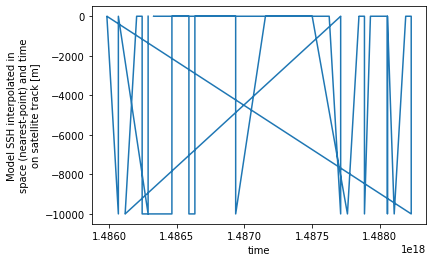

In [9]:
dsn.sossheig_np.plot()

### 2] Plot time series of _interpolated model_ SLA and satellite SLA

Even if probably ugly it gives the pictures of what we are dealing with...

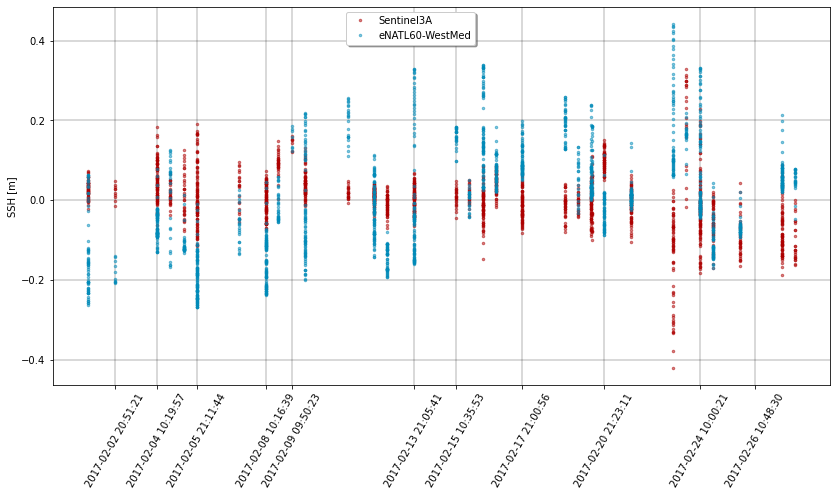

In [21]:
vmodel=dsn.sossheig_bl
vsat=dsn.sla_unfiltered

vmodel_mask=nmp.ma.masked_where(vmodel==-9.99900000e+03, vmodel)
vsat_mask=nmp.ma.masked_where(vmodel==-9.99900000e+03, vsat)

import matplotlib.dates as mdates
                                                                                                        
clr_sat = '#AD0000'
clr_mod = '#008ab8'

VT = dsn.time_counter ; # time from UNIX Epoch to Matlplotlib friendly...

fig = plt.figure(num = 1, figsize=(12,7), facecolor='w', edgecolor='k')
ax = plt.axes([0.07, 0.24, 0.9, 0.75])
ax.set_xticks(VT[::200])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation='60')
#plt.plot(VT, VT*0.0          , '-', color='k',                   label=None,  zorder=5)
plt.plot(VT, vsat_mask-nmp.mean(vsat_mask), '.', color=clr_sat, markersize=5, alpha=0.5, label=name_sat, zorder=10)
plt.plot(VT, vmodel_mask-nmp.mean(vmodel_mask), '.', color=clr_mod, markersize=5, alpha=0.5, label=name_mod, zorder=15)
#ax.set_ylim(-r_max_amp_ssh,r_max_amp_ssh) ;
#ax.set_xlim(VT[0],VT[-1])
plt.ylabel('SSH [m]')
ax.grid(color='k', linestyle='-', linewidth=0.3)
lgnd = plt.legend(bbox_to_anchor=(0.55, 1.), ncol=1, shadow=True, fancybox=True)


## Processing solution for spectral analysis
### 1] Select continuous segments, prepare them for FFT, and apply FFT on each of them

In [17]:
print(dsn.time.values)

[1.48632910e+18 1.48632911e+18 1.48632911e+18 ... 1.48628846e+18
 1.48628846e+18 1.48628846e+18]


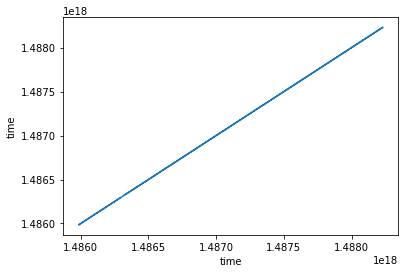

In [18]:
dsn.time.plot()

In [31]:
dsn.time_counter.values

array(['2017-02-05T21:11:44.566244096', '2017-02-05T21:11:45.566244096',
       '2017-02-05T21:11:46.566244096', ...,
       '2017-02-05T09:54:20.330564352', '2017-02-05T09:54:21.330564352',
       '2017-02-05T09:54:22.330564608'], dtype='datetime64[ns]')

In [32]:
dsn.time.values

array([1.48632910e+18, 1.48632911e+18, 1.48632911e+18, ...,
       1.48628846e+18, 1.48628846e+18, 1.48628846e+18])

In [28]:
# Extract the Ns continuous data segments:                                                                                                              
ISeg_beg, ISeg_end = gz.FindUnbrokenSegments( dsn.time_counter, dsn.distance, vmodel_mask, \
                                             rcut_time=1.2, rcut_dist=7.8 )


TypeError: '<' not supported between instances of 'Array' and 'float'

In [27]:
print(ISeg_beg, ISeg_end)

[   0    1    2 ... 2044 2045 2046] [   0    1    2 ... 2044 2045 2046]


In [25]:
# Extract the Ns continuous data segments:                                                                                                              
ISeg_beg, ISeg_end = gz.FindUnbrokenSegments( dsn.time_counter, dsn.distance, vmodel_mask, \
                                             rcut_time=1.2e+09, rcut_dist=7.8 )
# => any Δt > 1.2 s between 2 consecutive points is considered as a gap and hence a cut!
# => any Δd > 7.8 km    "               "             "                 "

# Select and retain only the "NbSeg" proper segments:                                                                                                               
NbSeg, Nsl, IDEDSeg = gz.SegmentSelection(ISeg_beg, ISeg_end, np_valid_seg=70)
# Debug validity check:                                                                                                                                       
#for js in range(NbSeg):                                                                                                                                
#    print(' * Seg # ',js+1,' => it1, it2 =', IDEDSeg[js,:], ' ==> len = ', IDEDSeg[js,1]-IDEDSeg[js,0]+1)                                              
#print(' Nsl = ',Nsl)

# Process data on segment so ready for FFT:                                                                                                 
XPs, XPm, rdist_sample = gz.Process4FFT( IDEDSeg, dsn.distance, vmodel_mask, vsat_mask )

# Apply FFT !                                                                                                                               
Kwn, PwSpc_s, PwSpc_m = gz.ApplyFFT( IDEDSeg, XPs, XPm, rdist_sample )


TypeError: '<' not supported between instances of 'Array' and 'float'

### 2] Plotting the mean spectrum

In [ ]:
CLIMPORN_DIR = '/Users/auraoupa/Work/git/climporn/python' ; # get it there: https://github.com/brodeau/climporn
sys.path.append(CLIMPORN_DIR)
import climporn as cp

# Building our spectrum as the mean of the NbSeg spectra:
vps_mod = nmp.mean(PwSpc_m[:,:],axis=0)
vps_sat = nmp.mean(PwSpc_s[:,:],axis=0)

# Blabla for the plot:
cinfrm = str(NbSeg)+' segments\n'+str(Nsl)+' points/segment\n'+r'$\Delta$d sat.: '+str(round(rdist_sample,1))+' km'

ii = cp.plot("pow_spectrum_ssh")(Kwn, vps_mod, clab1=name_mod+' ("'+name_ssh_mod+'")', clr1=clr_mod, lw1=5, \
                                 cinfo=cinfrm, logo_on=False, \
                                 L_min=13., L_max=500., P_min_y=-6, P_max_y=1, \
                                 l_show_k4=False, l_show_k5=True, l_show_k11o3=False, l_show_k2=True, \
                                 vk2=Kwn, vps2=vps_sat, clab2=name_sat+' ("'+name_ssh_sat+'")', clr2=clr_sat, lw2=4)
